In [29]:
from pyopenms import *
import matplotlib.pyplot as plt


In [30]:
def mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title):
    
    obs_int = [element / max(obs_int) for element in obs_int]  # relative intenstiy
    theo_int = [element * -1 for element in theo_int]  # invert the intensity for the mirror plot
    plt.figure(figsize=(12, 8))
    plt.bar(obs_mz, obs_int, width=3.0)
    plt.bar(theo_mz, theo_int, width=3.0)
    plt.title(title)
    plt.ylabel('intensity')
    plt.xlabel('m/z')
    plt.show()

In [31]:
protein_ids = []
peptide_ids = []
SimpleSearchEngineAlgorithm().search("yeast9.mzML", "yeast9.fasta", protein_ids, peptide_ids)

Peptide Index m/z: 4882
 - Peptide hit sequence: ELETQTK
Spectrum 1 of ELETQTK has 22 peaks.
y1++ is generated at m/z 74.06004069007102
b2++ is generated at m/z 122.070605753871
y2++ is generated at m/z 124.58388030172102
y1+ is generated at m/z 147.112804913371
b3++ is generated at m/z 186.591902865521
y3++ is generated at m/z 188.61316942932103
b4++ is generated at m/z 237.115742477171
y4++ is generated at m/z 239.13700904097104
b2+ is generated at m/z 243.13393504097098
y2+ is generated at m/z 248.16048413667102
b5++ is generated at m/z 301.145031604771
y5++ is generated at m/z 303.658306152621
b6++ is generated at m/z 351.668871216421
y6++ is generated at m/z 360.200338328071
b3+ is generated at m/z 372.176529264271
y3+ is generated at m/z 376.21906239187103
b4+ is generated at m/z 473.224208487571
y4+ is generated at m/z 477.26674161517104
b5+ is generated at m/z 601.282786742771
y5+ is generated at m/z 606.309335838471
b6+ is generated at m/z 702.330465966071
y6+ is generated at 

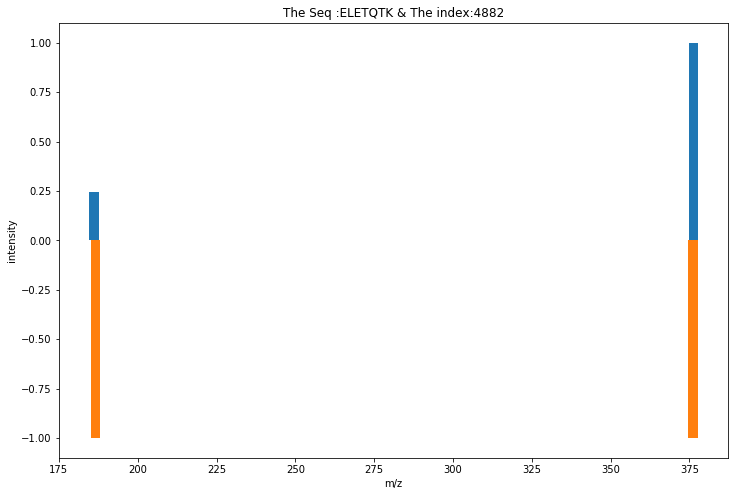

Peptide Index m/z: 8288
 - Peptide hit sequence: TLDTQLEIVIENLHK
Spectrum 1 of TLDTQLEIVIENLHK has 54 peaks.
y1++ is generated at m/z 74.06004069007102
b2++ is generated at m/z 108.073148253871
y2++ is generated at m/z 142.58949680172103
y1+ is generated at m/z 147.112804913371
b3++ is generated at m/z 165.586620333621
y3++ is generated at m/z 199.13152897717103
b2+ is generated at m/z 215.139020040971
b4++ is generated at m/z 216.110459945271
y4++ is generated at m/z 256.152993072871
b5++ is generated at m/z 280.13974907287104
y2+ is generated at m/z 284.171717136671
y5++ is generated at m/z 320.674290184521
b3+ is generated at m/z 330.165964200471
b6++ is generated at m/z 336.68178124832104
y6++ is generated at m/z 377.216322359971
y3+ is generated at m/z 397.255781487571
b7++ is generated at m/z 401.2030783599711
y7++ is generated at m/z 426.750529503521
b4+ is generated at m/z 431.21364342377103
b8++ is generated at m/z 457.7451105354211
y8++ is generated at m/z 483.292561678971
b9

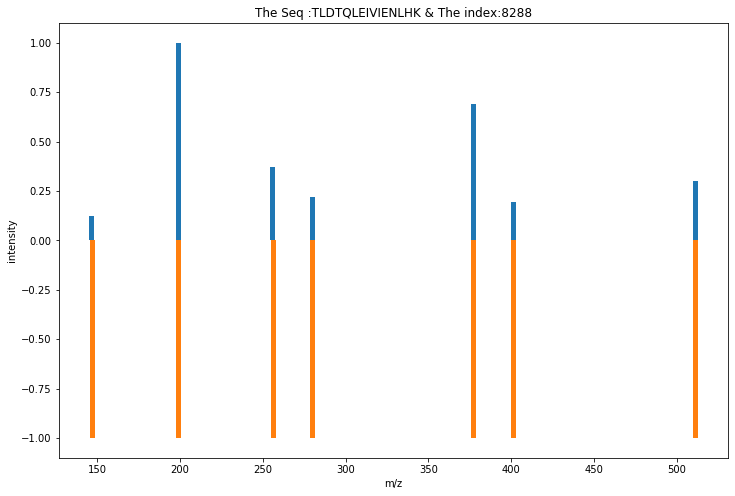

In [ ]:
for peptide_id in peptide_ids:
    print (35*"=")
    print ("Peptide Index m/z:", peptide_id.getMetaValue("scan_index"))
    for hit in peptide_id.getHits():
        index=str(peptide_id.getMetaValue("scan_index"))
        seq=str( hit.getSequence())
        print(" - Peptide hit sequence:", hit.getSequence())
        tsg = TheoreticalSpectrumGenerator()
        theo_spec = MSSpectrum()
        p = Param()
        p.setValue("add_y_ions", "true")
        p.setValue("add_b_ions", "true")
        p.setValue("add_metainfo", "true")
        tsg.setParameters(p)
        peptide = AASequence.fromString(hit.getSequence().toString())
        tsg.getSpectrum(theo_spec, peptide, 1, 2)
        # Iterate over annotated ions and their masses
        print("Spectrum 1 of", peptide, "has", theo_spec.size(), "peaks.")
        for ion, peak in zip(theo_spec.getStringDataArrays()[0], theo_spec):
            print(ion.decode(), "is generated at m/z", peak.getMZ())
        exp = MSExperiment()
        MzMLFile().load("yeast9.mzML", exp)
        spectra = exp.getSpectrum(peptide_id.getMetaValue("scan_index"))
        alignment = []
        spa = SpectrumAlignment()
        p = spa.getParameters()
        # use 0.5 Da tolerance (Note: for high-resolution data we could also use ppm by setting the is_relative_tolerance value to true)
        p.setValue("tolerance", 0.5)
        p.setValue("is_relative_tolerance", "false")
        spa.setParameters(p)
        # align both spectra
        spa.getSpectrumAlignment(alignment, theo_spec, spectra)

        # Print matching ions and mz from theoretical spectrum
        if(len(alignment)!=0):
            print("Number of matched peaks: " + str(len(alignment)))
            print("ion\ttheo. m/z\tobserved m/z")

        
            for theo_idx, obs_idx in alignment:
                ion_name = theo_spec.getStringDataArrays()[0][theo_idx].decode()
                ion_charge = theo_spec.getIntegerDataArrays()[0][theo_idx]
                print(ion_name + "\t" + str(ion_charge) + "\t"
                      + str(theo_spec[theo_idx].getMZ())
                      + "\t" + str(spectra[obs_idx].getMZ()))

            theo_mz, theo_int, obs_mz, obs_int = [], [], [], []
            for theo_idx, obs_idx in alignment:
                theo_mz.append(theo_spec[theo_idx].getMZ())
                theo_int.append(theo_spec[theo_idx].getIntensity())
                obs_mz.append(spectra[obs_idx].getMZ())
                obs_int.append(spectra[obs_idx].getIntensity())
            if(max(obs_int)!=0):
                title ="The Seq :"+ seq+" & The index:"+index
                mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title)
        
